# SNV Frequency Spectrum 

**Date**: 2019-10-07, modified 2019-01-21, modified 2021-04-21       
**Author**: Katarina Braun 

## Overview
This notebook plots SNV frequency spectrums.  

I will compare iSNV frequency spectrums before and after transmission as well as in virus groups. 

**From Moncla et al, 2019, bioRxiv (https://doi.org/10.1101/683151):**  
"Purifying selection removes new variants from the population, generating an excess of low-freq variants, while positive selection promotes accumulation of high-frequency polymorphisms. Exponential population expansion also causes excess low-frequency variation; however, while selection disproportionately affects nonsynonymous variants, demographic factors affect synonymous and nonsynonymous variants equally."

I'll look for evidence of postive vs purifying selection following the transmission event. And, at least for now, I'll look across the entire genome. I could theoretically plot these for each gene segment, but I don't know if I have enough SNP calls to make anything out of that. 

Y = proportion of SNVs
X = within-host SNV frequency bins: 1-10%, 10-20%, 20-30%, 30-40%, 40-50%

I will also try to derive the "neutral expectation" -- that is the distribution of SNPs expected for a given population assuming that the population is not under selection and is at some sort of steady-state equilibrium. 

For the neutral expectation, Trevor Bedford suggests this will follow a 1/x distribution. I can then just integrate over a 1/x distribution between each bin size (0.01 to 0.1, 0.1 to 0.2, etc...). Then I'll calculate the proportion of the total that fall into each bin. Dr. Louise Moncal (cited above) already prepared a notebook to do this: `neutral-expectation.ipynb`, which I am going to utilize here. 
    
### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 

## Input: 

- annotated VCF files that Sniffles outputs: `H7N9/data_derived/iSNVs/vcfs-intersection/*`
 

## Output: 
- `H7N9/figures/SFS/*`

## import modules and dependecies 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import cycle, islice
import random 
from pylab import *
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec

## Add in neutral expectation as a dashed line

The neutral expectation code is from Dr. Louise Moncla (https://github.com/lmoncla). 

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value.

In [7]:
# define functions 

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [8]:
# predict neutral expectations for 10 bins 
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-99%"],"expected":proportions})
# neutral_df.set_index('bin', inplace=True)
neutral_df.rename(columns={'expected':'proportion'}, inplace=True)

In [9]:
neutral_df

,bin,proportion
0,1-10%,0.501094
1,10-20%,0.150844
2,20-30%,0.088238
3,30-40%,0.062606
4,40-50%,0.048561
5,50-60%,0.039677
6,60-70%,0.033547
7,70-80%,0.029059
8,80-90%,0.025632
9,90-99%,0.020742


In [24]:
neutral_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bin                  11 non-null     object 
 1   neutral expectation  11 non-null     float64
dtypes: float64(1), object(1)
memory usage: 308.0+ bytes


In [48]:
import pandas as pd
import glob
import os

# Define directories
input_dir = "iSNVs_by_sample_nonsyn_domstat/syn_non/"
output_dir = "SNV_frequency_bins/syn_non"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Define the frequency bins
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
bin_labels = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%',"50-60%","60-70%","70-80%","80-90%","90-99%"]

# Read and process each CSV file
file_list = glob.glob(f"{input_dir}/*.csv")

for file in file_list:
    # Read CSV
    df = pd.read_csv(file, usecols=["gene_pos", "avg_freq"])
    
    # Bin frequencies
    df["bin"] = pd.cut(df["avg_freq"], bins=bins, labels=bin_labels, include_lowest=True)

    # Calculate proportions
    bin_counts = df["bin"].value_counts(normalize=True).reset_index()
    bin_counts.columns = ["bin", "proportion"]

    # Ensure all bins are represented
    bin_counts = bin_counts.set_index("bin").reindex(bin_labels, fill_value=0).reset_index()

    # Save to new file
    output_filename = os.path.join(output_dir, os.path.basename(file).replace(".csv", "_bins.csv"))
    bin_counts.to_csv(output_filename, index=False)

print("Processing complete. Binned frequency files saved in 'SNV_frequency_bins'.")


Processing complete. Binned frequency files saved in 'SNV_frequency_bins'.


In [69]:
import pandas as pd
import glob
import os

# Define directories
input_dir = "iSNVs_by_sample_nonsyn_domstat/color/"
output_dir = "SNV_frequency_bins/color"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Define the frequency bins
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
bin_labels = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%',"50-60%","60-70%","70-80%","80-90%","90-99%"]

# Read and process each CSV file
file_list = glob.glob(f"{input_dir}/*.csv")

for file in file_list:
    # Read CSV
    df = pd.read_csv(file, usecols=["gene_pos", "avg_freq"])
    
    # Bin frequencies
    df["bin"] = pd.cut(df["avg_freq"], bins=bins, labels=bin_labels, include_lowest=True)

    # Calculate proportions
    bin_counts = df["bin"].value_counts(normalize=True).reset_index()
    bin_counts.columns = ["bin", "proportion"]

    # Ensure all bins are represented
    bin_counts = bin_counts.set_index("bin").reindex(bin_labels, fill_value=0).reset_index()

    # Save to new file
    output_filename = os.path.join(output_dir, os.path.basename(file).replace(".csv", "_bins.csv"))
    bin_counts.to_csv(output_filename, index=False)

print("Processing complete. Binned frequency files saved in 'SNV_frequency_bins'.")


Processing complete. Binned frequency files saved in 'SNV_frequency_bins'.


## Defines functions 

In [9]:
# def plot_SFS(sample,t1):
#     i = pd.read_csv('iSNVs_by_sample/*.csv', sep='\t')
#     # modify the dataframes to retain only SNP and frequency 
#     # drop any rows with SNPs between 99 and 100% frequency
#     i = i.drop(['gene_pos', 'Unnamed: 0'], 1)
#     if t1 is None: 
#         print("t1 = None")

import pandas as pd
import glob

def plot_SFS(sample, t1):
    # Read all CSV files in the directory
    file_list = glob.glob('SNV_frequency_bins/*_bins.csv')
    
    # Read and concatenate all CSV files into a single DataFrame
    df_list = [pd.read_csv(file, sep='\t') for file in file_list]
    i = pd.concat(df_list, ignore_index=True)

    t['bins'] = ['1-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-99%']
    final = t.set_index('bins')
    # final = pd.concat([t,neutral_df],axis=1)


    # generate a figure with sub-plots (one for each gene segment)
    fig = plt.figure(figsize=(6,6), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')
    gs = gridspec.GridSpec(2,5)

    ax1 = fig.add_subplot(gs[0,0:3]) #pair1

    # get right of top and right frame of each subplot
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)

    # set fontsize of axes 
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    final.plot(kind='bar', grid=False, figsize=(12,8), width=0.8, alpha=1, ax=ax1)
    neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.8, alpha=0.5, ax=ax1)

    ax1.set_title(sample, fontname='Arial', fontsize=14)
    ax1.set_facecolor('white')
    for tick in ax1.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax1.get_yticklabels():
        tick.set_fontname("Arial")
    ax1.set_ylim(0,1.0)
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
    ax1.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
    ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
    ax1.legend(loc=0, frameon=False, fontsize=10, ncol=1)

    # plt.savefig('../figures/SFS/' + sample + '_' + 'SFS.pdf', dpi=300)

#

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

def plot_SFS(sample, neutral_df):
    # Read all binned CSV files
    file_list = glob.glob('SNV_frequency_bins/*_bins.csv')
    
    for file in file_list:
        # Read the binned data
        df = pd.read_csv(file)

        # Ensure bin labels match expected format
        bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%',"50-60%","60-70%","70-80%","80-90%","90-99%"]
        
        df = df.set_index('bin').reindex(bins_order, fill_value=0).reset_index()
        merged_df = df.merge(neutral_df, on='bin', how='left', suffixes=('_observed', '_expected'))

        # Create plot
        fig, ax1 = plt.subplots(figsize=(6,6), facecolor='w')
        plt.style.use('default')
        mpl.rc('font', family='Arial')

        # Plot observed data
        ax1.bar(merged_df['bin'], merged_df['proportion_observed'], width=0.8, alpha=1, label='Observed', color='#007acc')

        # Plot neutral expectation as a grey overlay
        ax1.bar(merged_df['bin'], merged_df['proportion_expected'], width=0.8, alpha=0.5, color='lightgrey', label='Neutral Expectation')

        # Formatting
        ax1.set_title(sample, fontname='Arial', fontsize=14)
        ax1.set_facecolor('white')
        ax1.set_ylim(0, 1.0)
        ax1.set_ylabel('Proportion of SNVs', fontname='Arial', fontsize=12)
        ax1.set_xlabel('Within-host SNV Frequency (%)', fontname='Arial', fontsize=12)
        ax1.set_xticklabels(bins_order, fontname='Arial', fontsize=10, rotation=45)
        ax1.legend(loc='best', frameon=False, fontsize=10)

        # Show or save plot
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'../figures/SFS/{sample}_SFS.pdf', dpi=300)

    print("Plots generated successfully.")

# Call function
plot_SFS("Sample1", neutral_df)


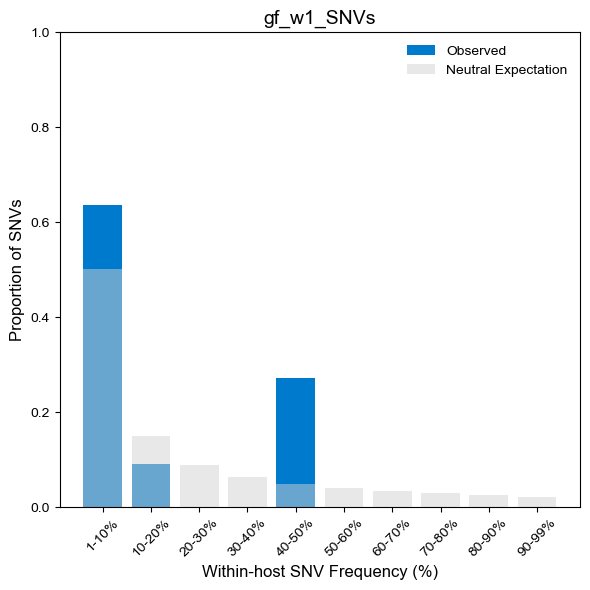

Plot generated successfully for gf_w1_SNVs.


In [64]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_SFS(sample_name, neutral_df):
    # Construct the file path for the specific sample
    file_path = f'SNV_frequency_bins/{sample_name}_bins.csv'
    
    # Check if the file exists
    if file_path not in glob.glob('SNV_frequency_bins/*_bins.csv'):
        print(f"Error: No file found for sample '{sample_name}' in 'SNV_frequency_bins/'.")
        return

    # Read the binned data
    df = pd.read_csv(file_path)

    # Ensure bin labels match expected format
    bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%',"50-60%","60-70%","70-80%","80-90%","90-99%"]
    
    df = df.set_index('bin').reindex(bins_order, fill_value=0).reset_index()
    merged_df = df.merge(neutral_df, on='bin', how='left', suffixes=('_observed', '_expected'))

    # Create plot
    fig, ax1 = plt.subplots(figsize=(6,6), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')

    # Plot observed data
    ax1.bar(merged_df['bin'], merged_df['proportion_observed'], width=0.8, alpha=1, label='Observed', color='#007acc')

    # Plot neutral expectation as a grey overlay
    ax1.bar(merged_df['bin'], merged_df['proportion_expected'], width=0.8, alpha=0.5, color='lightgrey', label='Neutral Expectation')

    # Formatting
    ax1.set_title(sample_name, fontname='Arial', fontsize=14)
    ax1.set_facecolor('white')
    ax1.set_ylim(0, 1.0)
    ax1.set_ylabel('Proportion of SNVs', fontname='Arial', fontsize=12)
    ax1.set_xlabel('Within-host SNV Frequency (%)', fontname='Arial', fontsize=12)
    ax1.set_xticks(range(len(bins_order)))
    ax1.set_xticklabels(bins_order, fontname='Arial', fontsize=10, rotation=45)
    ax1.legend(loc='best', frameon=False, fontsize=10)

    # Save plot with sample name
    plt.tight_layout()
    # plt.savefig(f'../figures/SFS/{sample_name}_SFS.pdf', dpi=300)
    plt.show()

    print(f"Plot generated successfully for {sample_name}.")

# Call function with a specific sample name
plot_SFS("gf_w1_SNVs", neutral_df)


In [40]:
import pandas as pd
import glob

# Get all binned frequency files
file_list = glob.glob('SNV_frequency_bins/*_bins.csv')

# Read and concatenate all files into a single DataFrame
df_list = [pd.read_csv(file) for file in file_list]
all_bins_df = pd.concat(df_list, ignore_index=True)

# Ensure bin labels are consistent
bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%',"50-60%","60-70%","70-80%","80-90%","90-99%"]


# Compute mean and standard deviation for each bin
avg_bins = all_bins_df.groupby('bin')['proportion'].agg(['mean', 'std']).reset_index()

# Ensure bins are in the correct order
avg_bins = avg_bins.set_index('bin').reindex(bins_order).reset_index()

# Save to CSV
avg_bins.to_csv('avg_bins_allsamples_allSNVs.csv', index=False)

print("Average bin proportions saved to avg_bins.csv")
avg_bins

Average bin proportions saved to avg_bins.csv


,bin,mean,std
0,1-10%,0.778528,0.266839
1,10-20%,0.145963,0.235886
2,20-30%,0.032089,0.077758
3,30-40%,0.023321,0.066668
4,40-50%,0.020100,0.054527
5,50-60%,0.000000,0.000000
6,60-70%,0.000000,0.000000
7,70-80%,0.000000,0.000000
8,80-90%,0.000000,0.000000
9,90-99%,0.000000,0.000000


In [84]:
import pandas as pd
import glob

# Get all binned frequency files
file_list = glob.glob('SNV_frequency_bins/syn_non/*_bins.csv')

# Separate files into synonymous and nonsynonymous groups
syn_files = [file for file in file_list if "_synonymous_SNVs" in file]
nonsyn_files = [file for file in file_list if "_nonsynonymous_SNVs" in file]

# Read and concatenate all files into DataFrames
syn_df_list = [pd.read_csv(file) for file in syn_files]
nonsyn_df_list = [pd.read_csv(file) for file in nonsyn_files]

# Concatenate into full DataFrames
syn_all_bins_df = pd.concat(syn_df_list, ignore_index=True)
nonsyn_all_bins_df = pd.concat(nonsyn_df_list, ignore_index=True)

# Define bin order
bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%']

# Compute mean and standard deviation for each bin
syn_avg_bins = syn_all_bins_df.groupby('bin')['proportion'].agg(mean_syn='mean', std_syn='std').reset_index()
nonsyn_avg_bins = nonsyn_all_bins_df.groupby('bin')['proportion'].agg(mean_nonsyn='mean', std_nonsyn='std').reset_index()

# Merge both DataFrames on 'bin'
avg_bins = pd.merge(syn_avg_bins, nonsyn_avg_bins, on='bin', how='outer')

# Ensure bins are in the correct order
avg_bins = avg_bins.set_index('bin').reindex(bins_order).reset_index()

# Save to CSV
# avg_bins.to_csv('avg_bins_allsamples_syn_vs_nonsyn.csv', index=False)

print("Average bin proportions for synonymous and nonsynonymous saved to avg_bins_allsamples_syn_vs_nonsyn.csv")
avg_bins


Average bin proportions for synonymous and nonsynonymous saved to avg_bins_allsamples_syn_vs_nonsyn.csv


,bin,mean_syn,std_syn,mean_nonsyn,std_nonsyn
0,1-10%,0.784862,0.335998,0.746922,0.332556
1,10-20%,0.157190,0.312275,0.128223,0.226113
2,20-30%,0.035175,0.166749,0.070707,0.212583
3,30-40%,0.010804,0.044066,0.028283,0.094326
4,40-50%,0.011969,0.042527,0.025866,0.084265
5,50-60%,0.000000,0.000000,0.000000,0.000000
6,60-70%,0.000000,0.000000,0.000000,0.000000
7,70-80%,0.000000,0.000000,0.000000,0.000000
8,80-90%,0.000000,0.000000,0.000000,0.000000
9,90-99%,0.000000,0.000000,0.000000,0.000000


In [73]:
import pandas as pd
import glob

# Get all binned frequency files
file_list = glob.glob('SNV_frequency_bins/color/*_bins.csv')

# Separate files into synonymous and nonsynonymous groups for each category
wsyn_files = [file for file in file_list if "_wild_synonymous_SNVs" in file]
wnonsyn_files = [file for file in file_list if "_wild_nonsynonymous_SNVs" in file]
csyn_files = [file for file in file_list if "_commercial_synonymous_SNVs" in file]
cnonsyn_files = [file for file in file_list if "_commercial_nonsynonymous_SNVs" in file]

# Read and concatenate all files into DataFrames for each category
wsyn_df_list = [pd.read_csv(file) for file in wsyn_files]
wnonsyn_df_list = [pd.read_csv(file) for file in wnonsyn_files]
csyn_df_list = [pd.read_csv(file) for file in csyn_files]
cnonsyn_df_list = [pd.read_csv(file) for file in cnonsyn_files]

# Concatenate into full DataFrames
wsyn_all_bins_df = pd.concat(wsyn_df_list, ignore_index=True)
wnonsyn_all_bins_df = pd.concat(wnonsyn_df_list, ignore_index=True)
csyn_all_bins_df = pd.concat(csyn_df_list, ignore_index=True)
cnonsyn_all_bins_df = pd.concat(cnonsyn_df_list, ignore_index=True)

# Define bin order
bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%']

# Compute mean and standard deviation for each bin and each category
wsyn_avg_bins = wsyn_all_bins_df.groupby('bin')['proportion'].agg(wmean_syn='mean', wstd_syn='std').reset_index()
wnonsyn_avg_bins = wnonsyn_all_bins_df.groupby('bin')['proportion'].agg(wmean_nonsyn='mean', wstd_nonsyn='std').reset_index()
csyn_avg_bins = csyn_all_bins_df.groupby('bin')['proportion'].agg(cmean_syn='mean', cstd_syn='std').reset_index()
cnonsyn_avg_bins = cnonsyn_all_bins_df.groupby('bin')['proportion'].agg(cmean_nonsyn='mean', cstd_nonsyn='std').reset_index()

# Merge all DataFrames on 'bin' column
avg_bins = pd.merge(wsyn_avg_bins, wnonsyn_avg_bins, on='bin', how='outer')
avg_bins = pd.merge(avg_bins, csyn_avg_bins, on='bin', how='outer')
avg_bins = pd.merge(avg_bins, cnonsyn_avg_bins, on='bin', how='outer')

# Ensure bins are in the correct order
avg_bins = avg_bins.set_index('bin').reindex(bins_order).reset_index()

# Save the results to CSV
avg_bins.to_csv('avg_bins_allsamples_domstat_syn_non.csv', index=False)

print("Average bin proportions for all categories saved to avg_bins_allsamples_domstat_syn_non.csv")
avg_bins


Average bin proportions for all categories saved to avg_bins_allsamples_domstat_syn_non.csv


,bin,wmean_syn,wstd_syn,wmean_nonsyn,wstd_nonsyn,cmean_syn,cstd_syn,cmean_nonsyn,cstd_nonsyn
0,1-10%,0.810740,0.333038,0.728084,0.355023,0.737088,0.349695,0.784596,0.294736
1,10-20%,0.129835,0.284011,0.128193,0.250214,0.207692,0.365631,0.128283,0.179255
2,20-30%,0.049020,0.205730,0.068182,0.233781,0.009615,0.034669,0.075758,0.172621
3,30-40%,0.006239,0.021660,0.042424,0.113707,0.019231,0.069338,0.000000,0.000000
4,40-50%,0.004167,0.020412,0.033117,0.099892,0.026374,0.065425,0.011364,0.037689
5,50-60%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,60-70%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,70-80%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,80-90%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,90-99%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


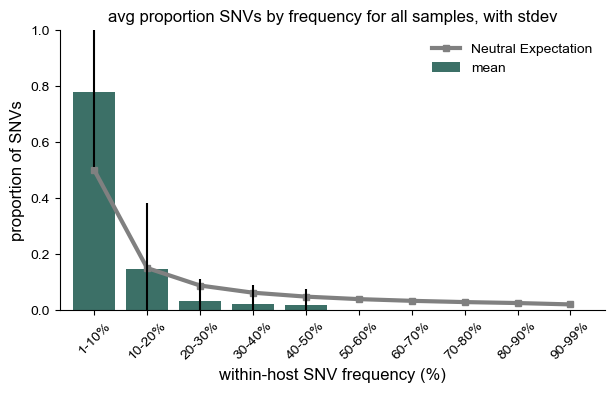

In [47]:
# plot the above dataframes 

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(6,6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2,5)

ax1 = fig.add_subplot(gs[0,0:3])

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

neutral_df.plot(kind='line', grid=False, color='grey', figsize=(12,8), alpha=1, linewidth=3, marker="s", markersize=5, ax=ax1)
avg_bins[['mean']].plot(kind='bar', yerr=avg_bins[['std']].values.T, color=['#3C7067','#C15D1A','#00A1C6','#890B0B'], ecolor='black', grid=False, figsize=(12,8), width=0.8, alpha=1, ax=ax1)

ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)
# Get the legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Modify only the neutral expectation label
labels[0] = "Neutral Expectation"  # Assuming neutral_df is the first plotted dataset

# Update the legend with the modified labels
ax1.legend(handles, labels, loc=0, frameon=False, fontsize=10, ncol=1)
ax1.set_title('avg proportion SNVs by frequency for all samples, with stdev')
plt.savefig('binned_SNVfreq_allsamples.pdf', dpi=300)


In [2]:
import pandas as pd
import glob

# Get all binned frequency files
file_list = glob.glob('SNV_frequency_bins/gf/*_bins.csv')

# Separate files into synonymous and nonsynonymous groups
syn_files = [file for file in file_list if "_synonymous_SNVs" in file]
nonsyn_files = [file for file in file_list if "_nonsynonymous_SNVs" in file]

# Read and concatenate all files into DataFrames
syn_df_list = [pd.read_csv(file) for file in syn_files]
nonsyn_df_list = [pd.read_csv(file) for file in nonsyn_files]

# Concatenate into full DataFrames
syn_all_bins_df = pd.concat(syn_df_list, ignore_index=True)
nonsyn_all_bins_df = pd.concat(nonsyn_df_list, ignore_index=True)

# Define bin order
bins_order = ['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%']

# Compute mean and standard deviation for each bin
syn_avg_bins = syn_all_bins_df.groupby('bin')['proportion'].agg(mean_syn='mean', std_syn='std').reset_index()
nonsyn_avg_bins = nonsyn_all_bins_df.groupby('bin')['proportion'].agg(mean_nonsyn='mean', std_nonsyn='std').reset_index()

# Merge both DataFrames on 'bin'
avg_bins = pd.merge(syn_avg_bins, nonsyn_avg_bins, on='bin', how='outer')

# Ensure bins are in the correct order
avg_bins = avg_bins.set_index('bin').reindex(bins_order).reset_index()

# Save to CSV
# avg_bins.to_csv('avg_bins_allsamples_syn_vs_nonsyn.csv', index=False)

print("Average bin proportions for synonymous and nonsynonymous saved to avg_bins_allsamples_syn_vs_nonsyn.csv")
avg_bins


Average bin proportions for synonymous and nonsynonymous saved to avg_bins_allsamples_syn_vs_nonsyn.csv


,bin,mean_syn,std_syn,mean_nonsyn,std_nonsyn
0,1-10%,1.0,0.0,0.809524,0.329914
1,10-20%,0.0,0.0,0.047619,0.082479
2,20-30%,0.0,0.0,0.000000,0.000000
3,30-40%,0.0,0.0,0.000000,0.000000
4,40-50%,0.0,0.0,0.142857,0.247436
5,50-60%,0.0,0.0,0.000000,0.000000
6,60-70%,0.0,0.0,0.000000,0.000000
7,70-80%,0.0,0.0,0.000000,0.000000
8,80-90%,0.0,0.0,0.000000,0.000000
9,90-99%,0.0,0.0,0.000000,0.000000


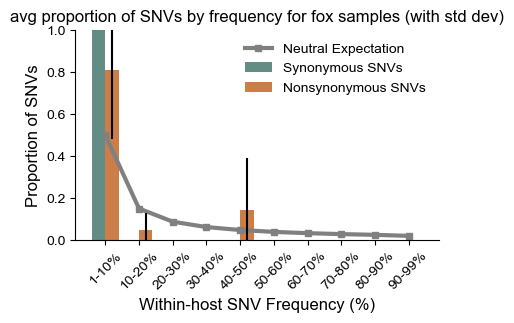

In [13]:
##plot binned frequency proportions by synonymous vs. nonsynonymous all samples

# Define bar width and position offset
bar_width = 0.4  # Width of bars
bin_positions = np.arange(len(avg_bins['bin']))  # Get numeric positions for bins

# Generate figure
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2,5)

ax1 = fig.add_subplot(gs[0,0:3])

# Remove top and right frame
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Set fontsize of axes
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# Plot neutral expectation as a line
neutral_df.plot(kind='line', grid=False, color='grey', alpha=1, linewidth=3, marker="s", markersize=5, ax=ax1, label="Neutral Expectation")

# Plot synonymous and nonsynonymous bars side by side
ax1.bar(bin_positions - bar_width/2, avg_bins['mean_syn'], yerr=avg_bins['std_syn'], 
        color='#3C7067', ecolor='black', alpha=0.8, width=bar_width, label="Synonymous SNVs")

ax1.bar(bin_positions + bar_width/2, avg_bins['mean_nonsyn'], yerr=avg_bins['std_nonsyn'], 
        color='#C15D1A', ecolor='black', alpha=0.8, width=bar_width, label="Nonsynonymous SNVs")

# Formatting
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")

ax1.set_ylim(0, 1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('Proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('Within-host SNV Frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticks(bin_positions)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], 
                     fontname='Arial', fontsize=10, minor=False, rotation=45)

# Get the legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Modify only the neutral expectation label
labels[0] = "Neutral Expectation"  # Assuming neutral_df is the first plotted dataset

# Update the legend with the modified labels
ax1.legend(handles, labels, loc=0, frameon=False, fontsize=10, ncol=1)

ax1.set_title('avg proportion of SNVs by frequency for fox samples (with std dev)', fontsize=12)
plt.savefig('output_figs/binned_SNVfreq_syn_vs_nonsyn_gf.pdf', dpi=300)

plt.show()


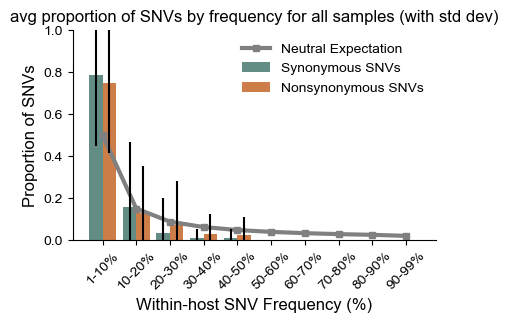

In [55]:
##plot binned frequency proportions by synonymous vs. nonsynonymous all samples

# Define bar width and position offset
bar_width = 0.4  # Width of bars
bin_positions = np.arange(len(avg_bins['bin']))  # Get numeric positions for bins

# Generate figure
fig = plt.figure(figsize=(8,6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2,5)

ax1 = fig.add_subplot(gs[0,0:3])

# Remove top and right frame
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Set fontsize of axes
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# Plot neutral expectation as a line
neutral_df.plot(kind='line', grid=False, color='grey', alpha=1, linewidth=3, marker="s", markersize=5, ax=ax1, label="Neutral Expectation")

# Plot synonymous and nonsynonymous bars side by side
ax1.bar(bin_positions - bar_width/2, avg_bins['mean_syn'], yerr=avg_bins['std_syn'], 
        color='#3C7067', ecolor='black', alpha=0.8, width=bar_width, label="Synonymous SNVs")

ax1.bar(bin_positions + bar_width/2, avg_bins['mean_nonsyn'], yerr=avg_bins['std_nonsyn'], 
        color='#C15D1A', ecolor='black', alpha=0.8, width=bar_width, label="Nonsynonymous SNVs")

# Formatting
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")

ax1.set_ylim(0, 1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('Proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('Within-host SNV Frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticks(bin_positions)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], 
                     fontname='Arial', fontsize=10, minor=False, rotation=45)

# Get the legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Modify only the neutral expectation label
labels[0] = "Neutral Expectation"  # Assuming neutral_df is the first plotted dataset

# Update the legend with the modified labels
ax1.legend(handles, labels, loc=0, frameon=False, fontsize=10, ncol=1)

ax1.set_title('avg proportion of SNVs by frequency for all samples (with std dev)', fontsize=12)
plt.savefig('binned_SNVfreq_syn_vs_nonsyn_sidebyside.pdf', dpi=300)

plt.show()


In [68]:
# compare neutral distribution vs SFS for each virus subgroup 
##will need to redo once I deterine cut-off and also remove 50-100% from this calculation

from scipy.stats import ks_2samp
import numpy as np

#KS test 
print(ks_2samp(avg_bins['mean_syn'], neutral_df['proportion']))
print(ks_2samp(avg_bins['mean_nonsyn'], neutral_df['proportion']))
# print(ks_2samp(GD3a['g-avg'], neutral_df['neutral expectation']))
# print(ks_2samp(rGD3a['r-avg'], neutral_df['neutral expectation']))


KstestResult(statistic=0.7, pvalue=0.012340600575894691, statistic_location=0.011969111969111969, statistic_sign=1)
KstestResult(statistic=0.5, pvalue=0.16782134274394334, statistic_location=0.0, statistic_sign=1)


In [85]:
# Define the set of values you're interested in
subset_values = ['1-10%', '10-20% ', '20-30%', '30-40%', '40-50%']

# Filter the DataFrame using `isin()`
avg_bins50 = avg_bins[avg_bins['bin'].isin(subset_values)]
neutral50 = neutral_df[neutral_df['bin'].isin(subset_values)]

print(ks_2samp(avg_bins50['mean_syn'], neutral50['proportion']))
print(ks_2samp(avg_bins50['mean_nonsyn'], neutral50['proportion']))

KstestResult(statistic=0.75, pvalue=0.22857142857142862, statistic_location=0.035174880763116055, statistic_sign=1)
KstestResult(statistic=0.5, pvalue=0.7714285714285716, statistic_location=0.028282828282828285, statistic_sign=1)


In [65]:
avg_bins['mean_syn']

0    0.784862
1    0.157190
2    0.035175
3    0.010804
4    0.011969
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: mean_syn, dtype: float64

In [66]:
avg_bins['mean_nonsyn']

0    0.746922
1    0.128223
2    0.070707
3    0.028283
4    0.025866
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: mean_nonsyn, dtype: float64

In [32]:
neutral_df['neutral expectation']

bin
1-10%     0.501094
10-20%    0.150844
20-30%    0.088238
30-40%    0.062606
40-50%    0.048561
50-60%    0.039677
60-70%    0.033547
70-80%    0.029059
80-90%    0.025632
90-99%    0.020742
Name: neutral expectation, dtype: float64

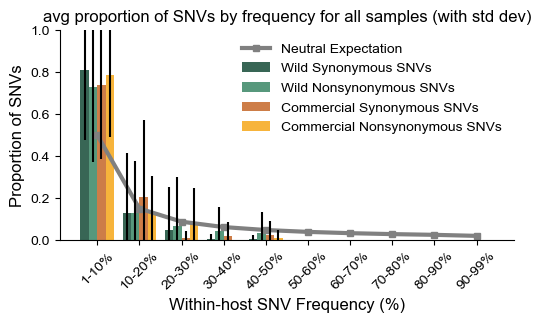

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

# Define bar width and position offset
bar_width = 0.2  # Adjusted width for 4 bars per bin
bin_positions = np.arange(len(avg_bins['bin']))  # Get numeric positions for bins

# Generate figure
fig = plt.figure(figsize=(10, 6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 5)

ax1 = fig.add_subplot(gs[0, 0:3])

# Remove top and right frame
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Set fontsize of axes
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# Plot neutral expectation as a line
neutral_df.plot(kind='line', grid=False, color='grey', alpha=1, linewidth=3, marker="s", markersize=5, ax=ax1, label="Neutral Expectation")

# Plot four bars (wild_synonymous, wild_nonsynonymous, commercial_synonymous, commercial_nonsynonymous) side by side
ax1.bar(bin_positions - 1.5 * bar_width, avg_bins['wmean_syn'], yerr=avg_bins['wstd_syn'], 
        color='#06402B', ecolor='black', alpha=0.8, width=bar_width, label="Wild Synonymous SNVs")

ax1.bar(bin_positions - 0.5 * bar_width, avg_bins['wmean_nonsyn'], yerr=avg_bins['wstd_nonsyn'], 
        color='#2D7E5B', ecolor='black', alpha=0.8, width=bar_width, label="Wild Nonsynonymous SNVs")

ax1.bar(bin_positions + 0.5 * bar_width, avg_bins['cmean_syn'], yerr=avg_bins['cstd_syn'], 
        color='#C15D1A', ecolor='black', alpha=0.8, width=bar_width, label="Commercial Synonymous SNVs")

ax1.bar(bin_positions + 1.5 * bar_width, avg_bins['cmean_nonsyn'], yerr=avg_bins['cstd_nonsyn'], 
        color='#F5A10A', ecolor='black', alpha=0.8, width=bar_width, label="Commercial Nonsynonymous SNVs")

# Formatting
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")

ax1.set_ylim(0, 1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('Proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('Within-host SNV Frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticks(bin_positions)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], 
                     fontname='Arial', fontsize=10, minor=False, rotation=45)

# Get the legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Modify only the neutral expectation label
labels[0] = "Neutral Expectation"  # Assuming neutral_df is the first plotted dataset

# Update the legend with the modified labels
ax1.legend(handles, labels, loc=0, frameon=False, fontsize=10, ncol=1)

ax1.set_title('avg proportion of SNVs by frequency for all samples (with std dev)', fontsize=12)

# Save the figure
plt.savefig('binned_SNVfreq_syn_vs_nonsyn_domstat.pdf', dpi=300)

# Show the plot
plt.show()


In [82]:
# compare neutral distribution vs SFS for each virus subgroup 
##will need to redo once I deterine cut-off and also remove 50-100% from this calculation

from scipy.stats import ks_2samp
import numpy as np

# Define the set of values you're interested in
subset_values = ['1-10%', '10-20% ', '20-30%', '30-40%', '40-50%']

# Filter the DataFrame using `isin()`
avg_bins50 = avg_bins[avg_bins['bin'].isin(subset_values)]
neutral50 = neutral_df[neutral_df['bin'].isin(subset_values)]
# Display the resulting subset



#KS test 
print(ks_2samp(avg_bins50['wmean_syn'], neutral50['proportion']))
print(ks_2samp(avg_bins50['wmean_nonsyn'], neutral50['proportion']))
print(ks_2samp(avg_bins50['cmean_syn'], neutral50['proportion']))
print(ks_2samp(avg_bins50['cmean_nonsyn'], neutral50['proportion']))


KstestResult(statistic=0.5, pvalue=0.7714285714285716, statistic_location=0.00623885918003565, statistic_sign=1)
KstestResult(statistic=0.5, pvalue=0.7714285714285716, statistic_location=0.04242424242424243, statistic_sign=1)
KstestResult(statistic=0.75, pvalue=0.22857142857142862, statistic_location=0.02637362637362637, statistic_sign=1)
KstestResult(statistic=0.5, pvalue=0.7714285714285716, statistic_location=0.011363636363636364, statistic_sign=1)


### 

Anhui (is sig different than neutral)
Kolmogorov–Smirnov statistic (D) 0.7
P-value of Test (p)	0.0123

CA04 (is sig different than neutral)
Kolmogorov–Smirnov statistic (D) 0.7
P-value of Test (p)	0.0149

GD3 (is NOT sig different than neutral)
Kolmogorov–Smirnov statistic (D) 0.3
P-value of Test (p)	0.7869

rGD3 (is borderline)
Kolmogorov–Smirnov statistic (D) 0.6
P-value of Test (p)	0.0524
